# Bayesian Optimization
In this example a bayesian framework is defined to tune hyperparameter of a CNN using hyperopt library developed https://github.com/hyperopt
Bayesian optimization is a seuential model-based approach to solving problems. In particular, we prescribe a prior belief over the possible objective functions and then sequentially refine this model as data are observed via our updated beliefs-given data-on the likely ojective function we are optimizing.
https://www.cs.ox.ac.uk/people/nando.defreitas/publications/BayesOptLoop.pdf
This blog summarises bayesian optimization very thoroughly.
https://medium.com/vantageai/bringing-back-the-time-spent-on-hyperparameter-tuning-with-bayesian-optimisation-2e21a3198afb

The CNN is used to model fashion MNIST dataset.

## Loading fashion MNIST dataset and defining CNN
In this section we load the fashion mnist dataset which contains 10 classes of objects, and a CNN is defined for classification

In [188]:
# baseline cnn model for fashion mnist
import numpy as np
import pandas as pd
import random
import seaborn as sns
import time
from numpy import mean
from numpy import std
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from keras.datasets import fashion_mnist
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.optimizers import SGD

In [47]:
# load train and test dataset
def load_dataset():
	# load dataset
	(trainX, trainY), (testX, testY) = fashion_mnist.load_data()
	# reshape dataset to have a single channel
	trainX = trainX.reshape((trainX.shape[0], 28, 28, 1))
	testX = testX.reshape((testX.shape[0], 28, 28, 1))
	# one hot encode target values
	trainY = to_categorical(trainY)
	testY = to_categorical(testY)
	return trainX, trainY, testX, testY

In [48]:
# scale pixels
def prep_pixels(train, test):
	# convert from integers to floats
	train_norm = train.astype('float32')
	test_norm = test.astype('float32')
	# normalize to range 0-1
	train_norm = train_norm / 255.0
	test_norm = test_norm / 255.0
	# return normalized images
	return train_norm, test_norm


In [166]:
# define cnn model
def define_model(params):
	model = Sequential()
	model.add(Conv2D(filters = int(params['Kernels1']), kernel_size= (int(params['kernel_size1']),int(params['kernel_size1'])), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
	model.add(MaxPooling2D((2, 2)))
	model.add(Flatten())
	model.add(Dense(units = int(params['units1']), activation='relu', kernel_initializer='he_uniform'))
	model.add(Dense(10, activation='softmax'))
	# compile model
	opt = SGD(lr=params['LR'], momentum=0.9)
	model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
	return model

In [167]:
def evaluate_model(Model, dataX, dataY, n_folds):
	scores, histories = list(), list()
	# prepare cross validation
	kfold = KFold(n_folds, shuffle=True, random_state=1)
	# enumerate splits
	for train_ix, test_ix in kfold.split(dataX):

		# select rows for train and test
		trainX, trainY, testX, testY = dataX[train_ix], dataY[train_ix], dataX[test_ix], dataY[test_ix]
		# fit model
		history = Model.fit(trainX, trainY, epochs=10, batch_size=32, validation_data=(testX, testY), verbose=0)
		# evaluate model
		_, acc = Model.evaluate(testX, testY, verbose=0)
		print('> %.3f' % (acc * 100.0))
		# append scores
		scores.append(acc)
		histories.append(history)
	return scores, histories

## Hyper parameter tuning
Here the hyper parameter grid is defined to be used by the bayesian framework. They will be jointly discovered as optimum design choice. This framework has two main ingredients:
### 1) Probabilistic surrogate model:
This model consists of a prior distribution that captures the behaviour of the unknown objective function from the designer perspective, and an observation model that describes the data generation.
### 2) Loss function
It is a sequence of queries to be minimized.

In [191]:
# Defining the hyper parameter space
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope
from hyperopt.pyll.stochastic import sample
#%% Hyper parameter tuning
param_hyperopt = {
    'LR': hp.loguniform('lr', np.log(0.001), np.log(1)),
    'Kernels1': hp.uniform('Kernels1', 16, 48),
    'kernel_size1': hp.quniform('kernel_size', 3, 7, 5),
    'units1': hp.quniform('units', 50, 200, 8)
    }
param_space = param_hyperopt


## Seting up the hyperopt
After defining the parameter space, the hyperopt need to be initialized. One need to consider that the bayesian process always maximize the posteriori, therefore if one is after minimizing a function that function could be defined as (1 - of interest object). The maximization of the posteriori is done iteratively through the below process: 

For each iteration:

1) Find the set of hyperparameter values that maximise the Expected Improvement by optimising the selection function over the surrogate function.

2) Hand this hyperparameter combination to the objective function for evaluation — and retrieve the corresponding score.

3) Update the surrogate function along the feedback of the objective function by applying Bayes’ theorem.

In [192]:
#%% Hyperopt function for CNN fashion MNIST
def hyperopt(param_space, X_train, y_train, X_test, y_test, num_eval):
    
    start = time.time()
    
    def objective_function(params):
        clf = define_model(params)
        scores, histories = evaluate_model(clf, trainX, trainY, n_folds = 5)
        score = np.mean(scores)
        return {'loss': -score, 'status': STATUS_OK}

    trials = Trials()
    best_param = fmin(objective_function, 
                      param_space, 
                      algo=tpe.suggest, 
                      max_evals=num_eval, 
                      trials=trials,
                      rstate= np.random.RandomState(1))
    loss = [x['result']['loss'] for x in trials.trials]
    
    best_param_values = [x for x in best_param.values()]
    
    best_param_dic = {'LR' : best_param_values[2],
                     'Kernels1' : best_param_values[0],
                     'kernel_size1' : best_param_values[1],
                     'units1' : best_param_values[3]}
    
    clf_best = define_model(best_param_dic)
    
    clf_best.fit(trainX, trainY)
    Y_pred = clf_best.predict(testX)
    Y_pred = np.rint(Y_pred)
    from sklearn.metrics import accuracy_score
    accuracy_score(testY, Y_pred)
    
    print("")
    print("##### Results")
    print("Score best parameters: ", min(loss)*-1)
    print("Best parameters: ", best_param)
    print("Test Score: ", accuracy_score(testY, Y_pred))
    print("Time elapsed: ", time.time() - start)
    print("Parameter combinations evaluated: ", num_eval)
    
    return trials

In [193]:
trainX, trainY, testX, testY = load_dataset()
# prepare pixel data
trainX, testX = prep_pixels(trainX, testX)
# Hyper parameter tuning
num_eval = 75
results_hyperopt = hyperopt(param_hyperopt, trainX, trainY, testX, testY, num_eval)

> 84.842                                            
> 84.942                                            
> 84.850                                            
> 10.225                                            
> 9.983                                             
> 90.617                                                                         
> 91.808                                                                         
> 94.417                                                                         
> 95.292                                                                         
> 97.067                                                                         
> 89.533                                                                          
> 95.133                                                                          
> 98.408                                                                          
> 99.867                                                                    

In [194]:
# Retrieve Hyperopt scores
hyperopt_scores = [trial['result']['loss']*-1 for trial in results_hyperopt.trials]
hyperopt_scores = np.maximum.accumulate(hyperopt_scores)
print(hyperopt_scores)

[0.54968334 0.93839999 0.96586667 0.96586667 0.96586667 0.96923333
 0.96923333 0.96923333 0.96923333 0.96923333 0.96923333 0.96923333
 0.96923333 0.96923333 0.96923333 0.96923333 0.96923333 0.96923333
 0.96923333 0.96923333 0.96923333 0.96938332 0.9714     0.9714
 0.9714     0.9714     0.9714     0.9714     0.9714     0.9714
 0.9714     0.9714     0.9714     0.9714     0.9714     0.9714
 0.9714     0.9714     0.9714     0.9714     0.9714     0.9714
 0.9714     0.9714     0.9714     0.9714     0.9714     0.9714
 0.9714     0.9714     0.9714     0.9714     0.9714     0.9714
 0.9714     0.9714     0.9714     0.9714     0.9714     0.9714
 0.9714     0.9714     0.9714     0.9714     0.9714     0.9714
 0.9714     0.9714     0.9714     0.9714     0.9714     0.9714
 0.9714     0.9714     0.97208333]


Text(0,0.5,'Cross-Validation Score (accuracy, %)')

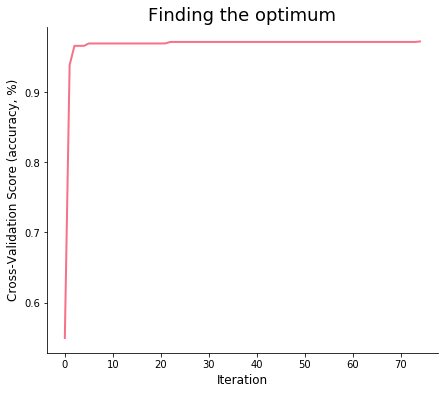

In [206]:
# Plot evaluation scores of each method over time
f, ax = plt.subplots(figsize=(7,6))
sns.set_palette("husl")
sns.despine()

ax = sns.lineplot(x=[x for x in range(num_eval)], y=hyperopt_scores, linewidth = 2)
plt.title("Finding the optimum", fontsize=18)
plt.xlabel('Iteration', fontsize=12)
plt.ylabel('Cross-Validation Score (accuracy, %)', fontsize=12)

## Plot hyperparameter distributions

In [196]:
# Randomly sample from learning rate and units distribution

learning_rate_space = {'LR': hp.loguniform('lr', np.log(0.001), np.log(1))}
unit1_space = {'units1': hp.quniform('units', 50, 200, 8)}

learning_rate_dist = [sample(learning_rate_space)['LR'] for x in range(1000)]
unit1_space_dist = [sample(unit1_space)['units1'] for x in range(1000)]

In [200]:
# Retrieve learning rates and num_leaves' used by Hyperopt
learning_rate_hp = [trial['misc']['vals']['lr'][0] for trial in results_hyperopt.trials]
units_hp = [trial['misc']['vals']['units'][0] for trial in results_hyperopt.trials]

[None, None]

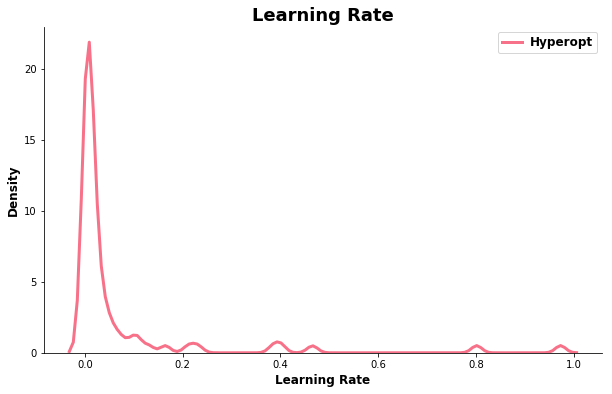

In [202]:
# Plot learning rate sampling distribution vs. values used by Hyperopt

f, ax = plt.subplots(figsize=(10,6))
sns.set_palette("husl")
sns.despine()
#ax = sns.kdeplot(learning_rate_dist, label = 'Sampling Distribution', linewidth = 3)
ax = sns.kdeplot(learning_rate_hp, label = 'Hyperopt', linewidth = 3)
plt.title("Learning Rate", fontsize=18, fontweight='bold')
plt.xlabel('Learning Rate', fontsize=12, fontweight='bold')
plt.ylabel('Density', fontsize=12, fontweight='bold');
plt.legend()
plt.setp(ax.get_legend().get_texts(), fontsize='12', fontweight='bold')

[None, None]

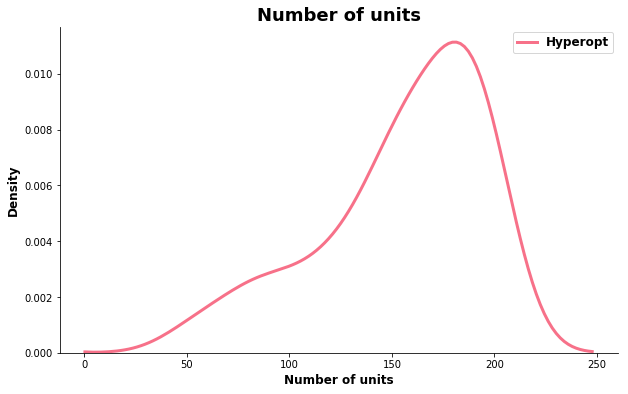

In [204]:
# Plot num_leaves sampling distribution vs. values used by Hyperopt

f, ax = plt.subplots(figsize=(10,6))
sns.set_palette("husl")
sns.despine()
ax = sns.kdeplot(units_hp, label = 'Hyperopt', linewidth = 3)
plt.title("Number of units", fontsize=18, fontweight='bold')
plt.xlabel('Number of units', fontsize=12, fontweight='bold')
plt.ylabel('Density', fontsize=12, fontweight='bold')
plt.legend()
plt.setp(ax.get_legend().get_texts(), fontsize='12', fontweight='bold')